<a href="https://colab.research.google.com/github/tincho-mehaudy/DMCyT/blob/master/TP1_Consigna1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install spotipy
!pip -q install -U librosa
#!wget -q https://www.dropbox.com/s/nqjs076fidighaz/SopSax.NoVib.mf.C4B4.wav?dl=1 -O SopSax.NoVib.mf.C4B4.wav

     |████████████████████████████████| 184kB 8.5MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 


In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials

# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

sns.set_context('poster')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Consigna 1:

Utilizando la API de Spotify se descargó la información de 4092 pistas de audio. Cada registro tiene variables de features de alto (*audio_features*), bajo nivel (*audio_analysis*) y metadata de los tracks. La idea es limpiar los campos a utilizar y hacer un primer análisis de los datos.

Para facilitar los primeros pasos utilizar una pequeña porción aleatoria de los datos e ir aumentando progresivamente. Observación: los datos de *audio_analysis* pesan 1.3 GB

# Dataset *tracks* 

-   De los datos de *tracks*, separar las etiquetas que se podrán utilizar para la validación externa (Artista, Álbum, Año, Género), de los campos que no se utilizarán.

# Dataset *audio_features*

El dataset *audio_features* contiene 9 atributos globales de alto nivel para cada pista de audio.

-   Con los datos de *audio_features*, generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

# Dataset *audio_analysis*

El dataset *audio_analysis* contiene las variables continuas de bajo nivel, estimadas en ventanas temporales, como *timbre* o *pitches*. Como primer paso, deberán:

-   Resumir estas variables en valores por canción. Por ejemplo, tomar el promedio o el desvío estándar del timbre entre todas las ventanas, obteniendo 12 valores de timbre promedio y 12 valores de desvío estándar del timbre por canción.

-   Contruir un *data frame* con estos valores.

-   Generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

## Bajamos los datos 



In [3]:
!wget https://www.dropbox.com/s/ms6260jqmsmz5qu/audio_features.pickle?dl=1 -O audio_features.pickle
!wget https://www.dropbox.com/s/8d0y9bms80ly8ui/tracks.pickle?dl=1 -O tracks.pickle
!wget https://www.dropbox.com/s/1cmb8e8zvv6hsfs/audio_analysis.pickle?dl=1 -O audio_analysis.pickle

--2020-09-28 22:10:28--  https://www.dropbox.com/s/ms6260jqmsmz5qu/audio_features.pickle?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ms6260jqmsmz5qu/audio_features.pickle [following]
--2020-09-28 22:10:29--  https://www.dropbox.com/s/dl/ms6260jqmsmz5qu/audio_features.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0f4f8eb0007525a5344095a547.dl.dropboxusercontent.com/cd/0/get/BATTVghGjebBMF8D6CaOIZ1VypRxMPEfSHaSS7Bh1d3etDji6tEoCtru5KEw-KQukUF6kFow15XU5imB3BOmqjj0L_gJAPwYkWxYlw_DCX0fi1QgZ2WfU-n1inR4NVZPRA4/file?dl=1# [following]
--2020-09-28 22:10:29--  https://uc0f4f8eb0007525a5344095a547.dl.dropboxusercontent.com/cd/0/get/BATTVghGjebBMF8D6CaOIZ1VypRxMPEfSHaSS7Bh1d3etDji6tEoCtru5KEw-KQukUF6kFow15XU5imB3B

In [4]:
import pandas as pd
import numpy as np

df_af = pd.read_pickle('audio_features.pickle')
df_tracks = pd.read_pickle('tracks.pickle')
df_aa = pd.read_pickle('audio_analysis.pickle')

# Dataset *tracks* 

-   De los datos de *tracks*, separar las etiquetas que se podrán utilizar para la validación externa (Artista, Álbum, Año, Género), de los campos que no se utilizarán.

In [23]:
df_tracks.head()

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,is_local,name,popularity,preview_url,track_number,type,uri,genre
id,,,,,,,,,,,,,,,,,
4d3XHYFFuYYzxWr2cJ6yQl,"{'album_type': 'ALBUM', 'artists': [{'external...",Tommy Flanagan,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,349600,False,{'isrc': 'USEWJ0702033'},{'spotify': 'https://open.spotify.com/track/4d...,https://api.spotify.com/v1/tracks/4d3XHYFFuYYz...,False,Angel Eyes - Studio,49,https://p.scdn.co/mp3-preview/10e213fc96d2f614...,3,track,spotify:track:4d3XHYFFuYYzxWr2cJ6yQl,jazz
3X3p3u03P8eFL8WTH0oaaU,"{'album_type': 'ALBUM', 'artists': [{'external...",Art Farmer,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,344066,False,{'isrc': 'USBN29100147'},{'spotify': 'https://open.spotify.com/track/3X...,https://api.spotify.com/v1/tracks/3X3p3u03P8eF...,False,Fair Weather - Remastered,47,None,2,track,spotify:track:3X3p3u03P8eFL8WTH0oaaU,jazz
4KlXeaheot0OI9PoOWspvZ,"{'album_type': 'ALBUM', 'artists': [{'external...",Christian Scott aTunde Adjuah,"[CA, US]",1,348746,False,{'isrc': 'USC4R0714598'},{'spotify': 'https://open.spotify.com/track/4K...,https://api.spotify.com/v1/tracks/4KlXeaheot0O...,False,Cease Fire,13,None,5,track,spotify:track:4KlXeaheot0OI9PoOWspvZ,jazz
3j76McoUI18gDoqxYE14Bu,"{'album_type': 'ALBUM', 'artists': [{'external...",Skalpel,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,275935,False,{'isrc': 'PLK281400008'},{'spotify': 'https://open.spotify.com/track/3j...,https://api.spotify.com/v1/tracks/3j76McoUI18g...,False,Sea,25,https://p.scdn.co/mp3-preview/d154ecaf7df8206c...,8,track,spotify:track:3j76McoUI18gDoqxYE14Bu,jazz
4zxd4tiXPlWMqoJltbVTbE,"{'album_type': 'ALBUM', 'artists': [{'external...",Miles Davis,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",2,284560,False,{'isrc': 'USSM15800962'},{'spotify': 'https://open.spotify.com/track/4z...,https://api.spotify.com/v1/tracks/4zxd4tiXPlWM...,False,Stella By Starlight,56,https://p.scdn.co/mp3-preview/a4430030bca4c02c...,3,track,spotify:track:4zxd4tiXPlWMqoJltbVTbE,jazz


In [24]:
df_tracks.columns

Index(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms',
       'explicit', 'external_ids', 'external_urls', 'href', 'is_local', 'name',
       'popularity', 'preview_url', 'track_number', 'type', 'uri', 'genre'],
      dtype='object')

In [25]:
df_tracks2 = df_tracks[['artists','album','genre']]
df_tracks2['release_date'] =df_tracks2['album'].apply(pd.Series)['release_date'].apply(str)
df_tracks2['release_date'] =df_tracks2['release_date'].str.slice(0, 4)

df_tracks2['album_name'] =df_tracks2['album'].apply(pd.Series)['name'].apply(str)

df_tracks2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,artists,album,genre,release_date,album_name
id,,,,,
4d3XHYFFuYYzxWr2cJ6yQl,Tommy Flanagan,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,1991,Master Trio
3X3p3u03P8eFL8WTH0oaaU,Art Farmer,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,1958,Modern Art
4KlXeaheot0OI9PoOWspvZ,Christian Scott aTunde Adjuah,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,2014,Christian Scott Collection
3j76McoUI18gDoqxYE14Bu,Skalpel,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,2014,Transit
4zxd4tiXPlWMqoJltbVTbE,Miles Davis,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,1959,Kind Of Blue (Legacy Edition)


In [26]:
df_tracks2[df_tracks2['release_date']=='0000']

,artists,album,genre,release_date,album_name
id,,,,,
2qij1qbQCOkjB8gsu3Y5lH,Super8 & Tab,"{'album_type': 'ALBUM', 'artists': [{'external...",trance,0000,Black Is The New Yellow
0gAD3qvhN777Izfn3sRjiN,Super8 & Tab,"{'album_type': 'ALBUM', 'artists': [{'external...",trance,0000,Above & Beyond Presents Anjunabeats Volume 5
5tmXe6SOpaA2KnNoBgI42R,Above & Beyond,"{'album_type': 'ALBUM', 'artists': [{'external...",trance,0000,Above & Beyond Presents Anjunabeats Volume 5


In [27]:
# completo los valores faltantes
df_tracks2.loc['2qij1qbQCOkjB8gsu3Y5lH','release_date']='2010'
df_tracks2.loc['0gAD3qvhN777Izfn3sRjiN','release_date']='2007'
df_tracks2.loc['5tmXe6SOpaA2KnNoBgI42R','release_date']='2007'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid d

# Dataset *audio_features*

El dataset *audio_features* contiene atributos globales de alto nivel para cada pista de audio.

-   Con los datos de *audio_features*, generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.


In [ ]:
df_af.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
id,,,,,,,,,,,,,,,,,
6avAsaa2IsXHT2mtQ6cGVe,0.6040,0.9630,7,-4.622,1,0.1250,0.00284,0.846000,0.0769,0.2750,172.020,audio_features,spotify:track:6avAsaa2IsXHT2mtQ6cGVe,https://api.spotify.com/v1/tracks/6avAsaa2IsXH...,https://api.spotify.com/v1/audio-analysis/6avA...,388663,4
6fvu2d6gHAdiNCMco4lTxK,0.0677,0.0581,2,-25.662,0,0.0402,0.99400,0.567000,0.1170,0.0372,73.509,audio_features,spotify:track:6fvu2d6gHAdiNCMco4lTxK,https://api.spotify.com/v1/tracks/6fvu2d6gHAdi...,https://api.spotify.com/v1/audio-analysis/6fvu...,283653,3
5GmrXcVIMgLaaqKVxhi5kp,0.2590,0.2420,2,-15.790,1,0.0401,0.53000,0.000003,0.0714,0.3050,178.132,audio_features,spotify:track:5GmrXcVIMgLaaqKVxhi5kp,https://api.spotify.com/v1/tracks/5GmrXcVIMgLa...,https://api.spotify.com/v1/audio-analysis/5Gmr...,213640,3
1DMIHggF47tqsO468VUDmd,0.2420,0.4450,4,-7.421,0,0.0318,0.49400,0.000224,0.1860,0.0867,86.289,audio_features,spotify:track:1DMIHggF47tqsO468VUDmd,https://api.spotify.com/v1/tracks/1DMIHggF47tq...,https://api.spotify.com/v1/audio-analysis/1DMI...,247933,4
78Ovt1QkZbU1QBMKWpcXPy,0.7010,0.8060,9,-5.508,1,0.1480,0.18300,0.003750,0.1230,0.9750,147.150,audio_features,spotify:track:78Ovt1QkZbU1QBMKWpcXPy,https://api.spotify.com/v1/tracks/78Ovt1QkZbU1...,https://api.spotify.com/v1/audio-analysis/78Ov...,168112,4


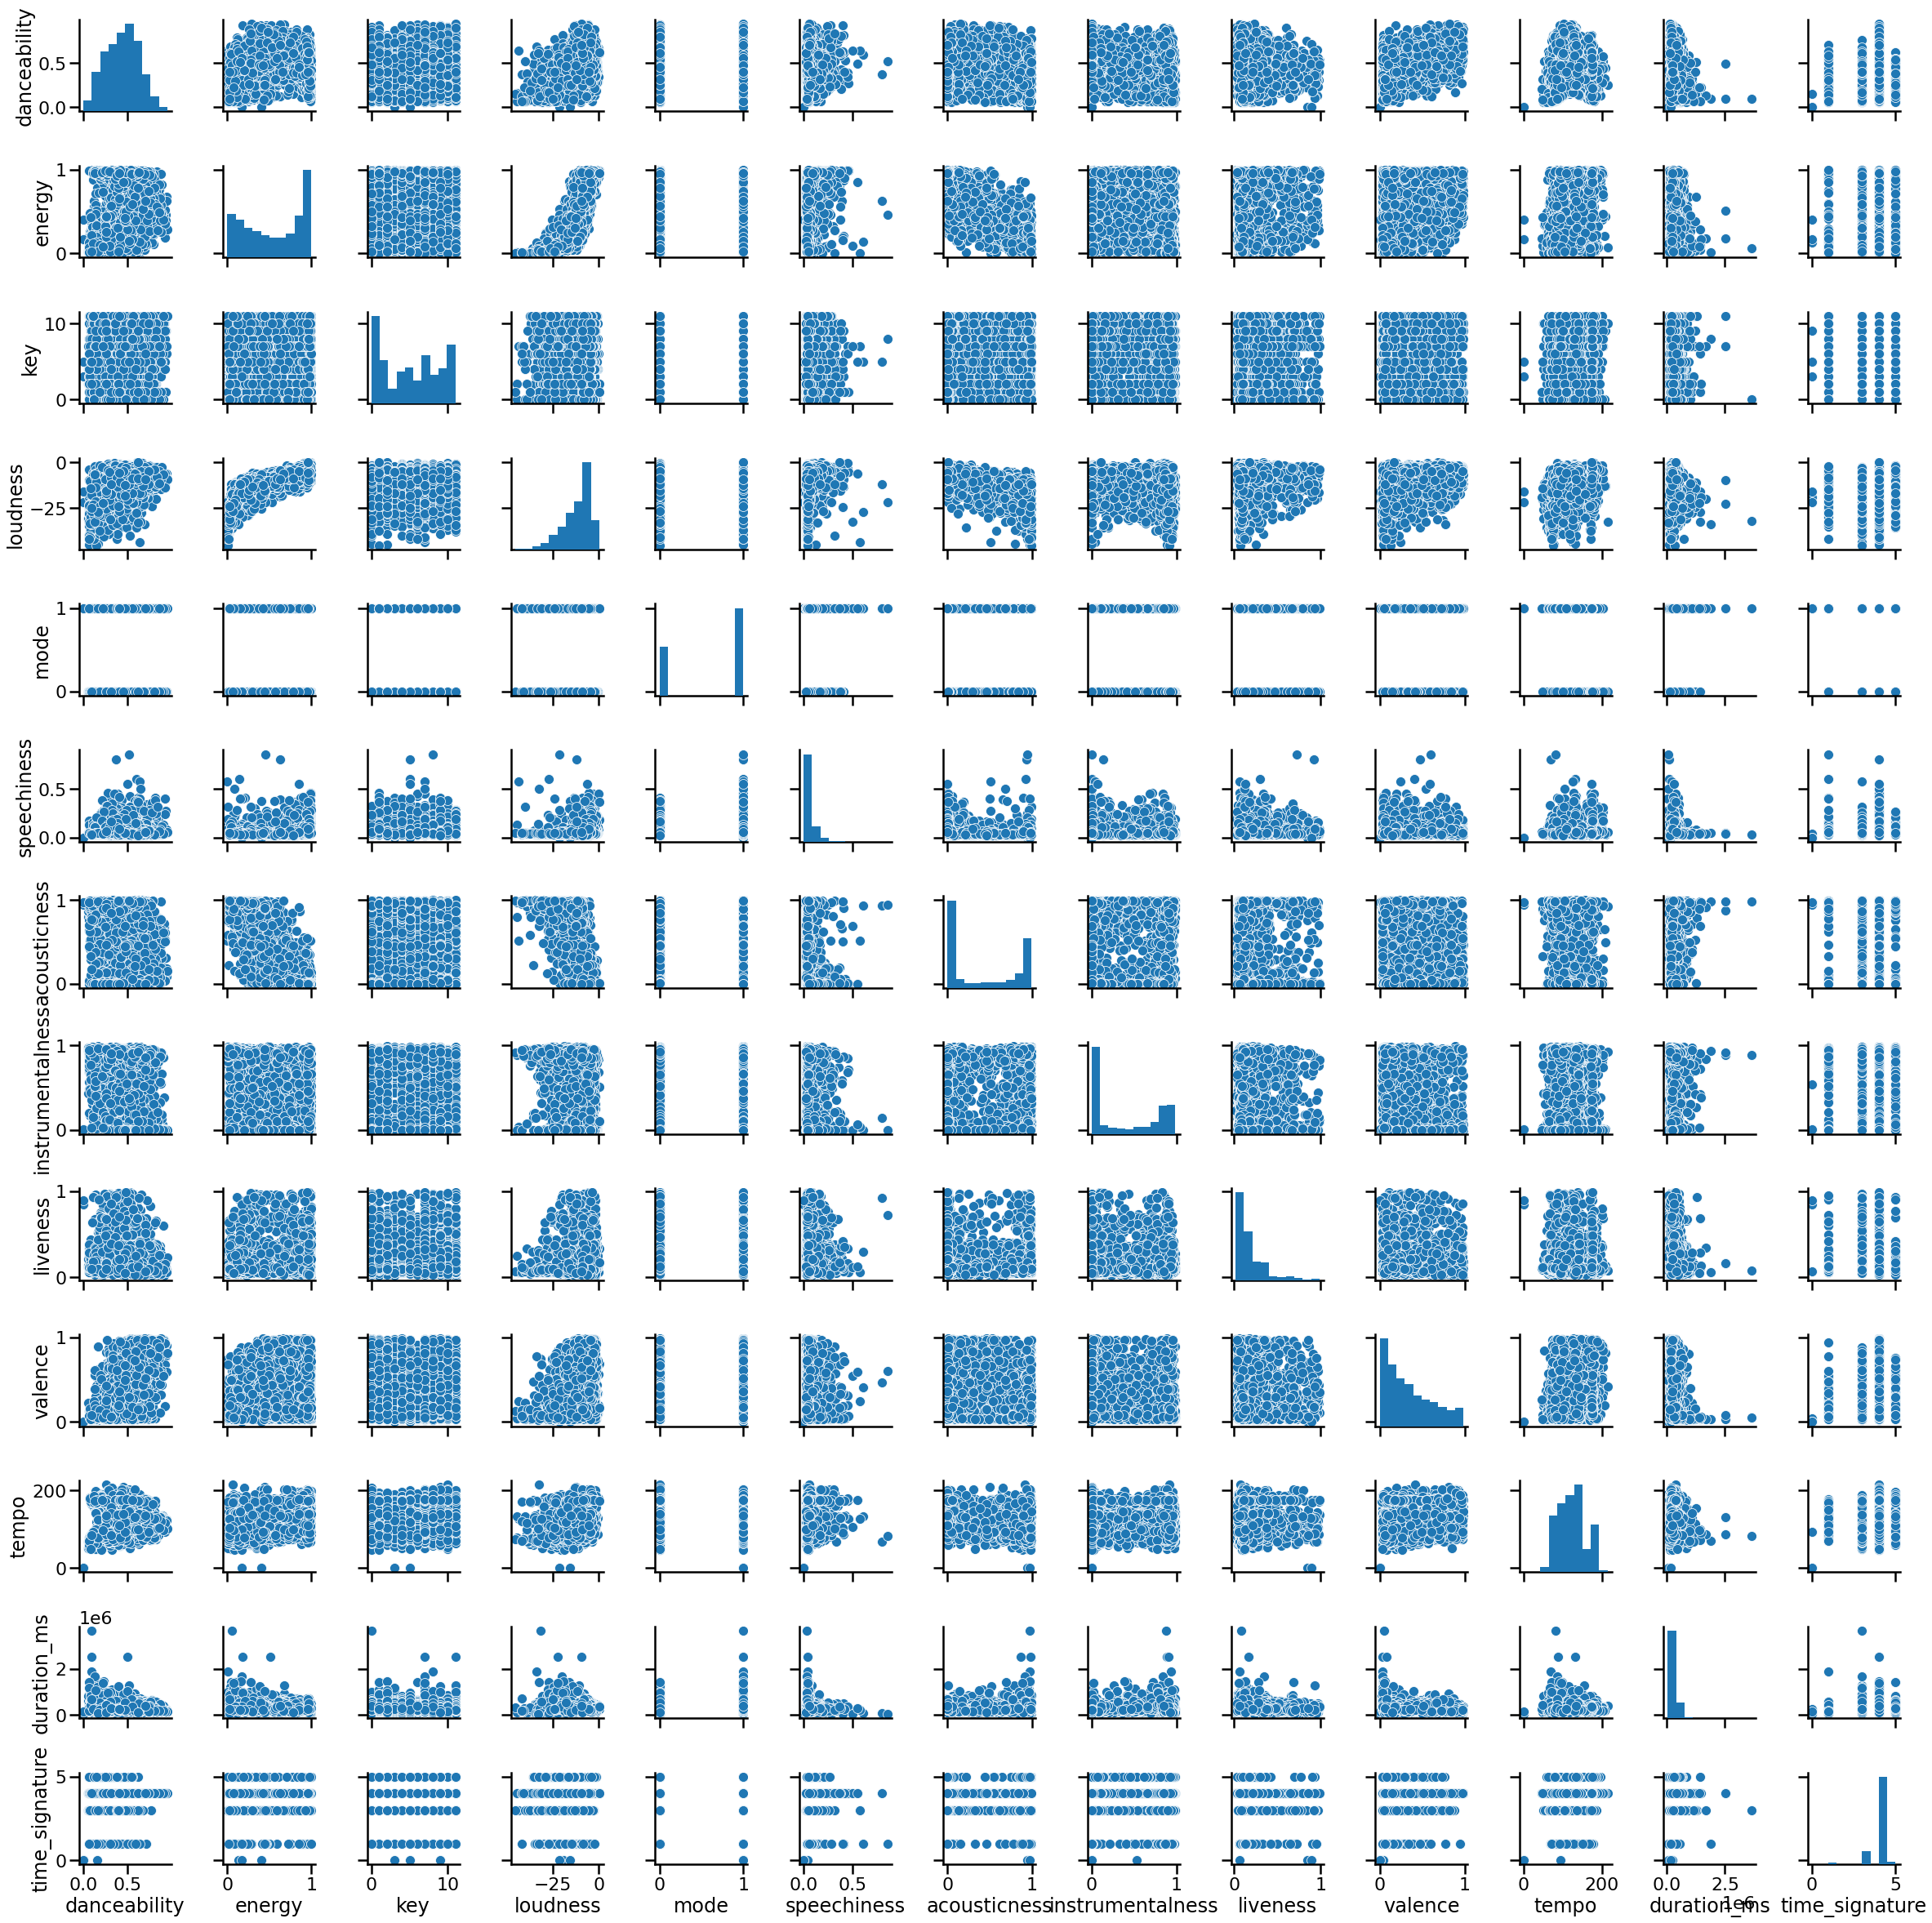

In [ ]:
sns.pairplot(df_af);

In [ ]:
# sacamos las variables string
df_af.drop('analysis_url', inplace=True, axis=1)
df_af.drop('track_href', inplace=True, axis=1)
df_af.drop('uri', inplace=True, axis=1)
df_af.drop('type', inplace=True, axis=1)

# y las categoricas
df_af.drop('key', inplace=True, axis=1)
df_af.drop('mode', inplace=True, axis=1)
df_af.drop('time_signature', inplace=True, axis=1)

In [ ]:
df_af.corr()
# existe alta correlacion entre 
#acousticness/energy, 
#acousticness/loudness,
#loudness/energy

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
danceability,1.000000,0.302459,0.405870,0.019451,-0.339075,-0.193985,-0.033091,0.587137,0.205519,-0.087575
energy,0.302459,1.000000,0.860182,0.344713,-0.895236,-0.078853,0.175633,0.339275,0.437383,-0.052145
loudness,0.405870,0.860182,1.000000,0.234375,-0.767183,-0.253148,0.143914,0.374012,0.408409,-0.091050
speechiness,0.019451,0.344713,0.234375,1.000000,-0.289173,-0.073044,0.140281,0.058777,0.141486,-0.095760
acousticness,-0.339075,-0.895236,-0.767183,-0.289173,1.000000,0.043314,-0.114591,-0.289461,-0.419675,-0.014671
instrumentalness,-0.193985,-0.078853,-0.253148,-0.073044,0.043314,1.000000,-0.054626,-0.291403,-0.027595,0.272892
liveness,-0.033091,0.175633,0.143914,0.140281,-0.114591,-0.054626,1.000000,0.008181,0.071132,-0.025698
valence,0.587137,0.339275,0.374012,0.058777,-0.289461,-0.291403,0.008181,1.000000,0.186940,-0.217588
tempo,0.205519,0.437383,0.408409,0.141486,-0.419675,-0.027595,0.071132,0.186940,1.000000,-0.003667
duration_ms,-0.087575,-0.052145,-0.091050,-0.095760,-0.014671,0.272892,-0.025698,-0.217588,-0.003667,1.000000


In [ ]:
df_af.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'],
      dtype='object')

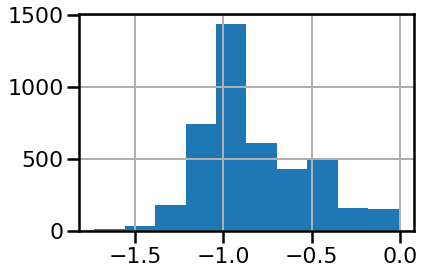

In [ ]:
df_af['liveness_log']=np.log10(df_af['liveness'])
df_af['liveness_log'].hist()
df_af.drop('liveness', inplace=True, axis=1)

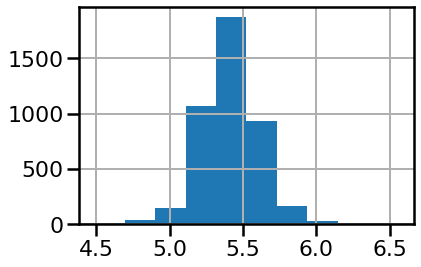

In [ ]:
df_af['duration_ms_log']=np.log10(df_af['duration_ms'])
df_af['duration_ms_log'].hist()
df_af.drop('duration_ms', inplace=True, axis=1)

In [ ]:
def logit(x):
  return np.log(1/((1/x)-1))

In [ ]:
def expo(x):
  return np.exp((1/x))

In [ ]:
def expo2(x):
  return np.exp(np.log10(x))

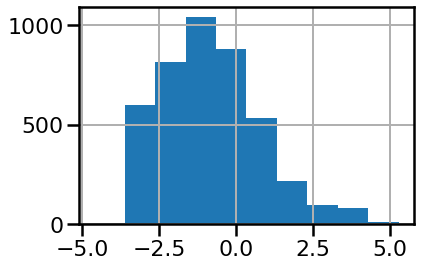

In [ ]:
df_af['valence_log']=(df_af['valence']+0.01).apply(logit)
df_af['valence_log'].hist()
df_af.drop('valence', inplace=True, axis=1)

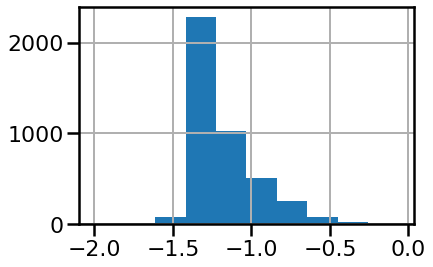

In [ ]:
df_af['speechiness_log']=(df_af['speechiness']+0.01).apply(np.log10)
df_af['speechiness_log'].hist()
df_af.drop('speechiness', inplace=True, axis=1)



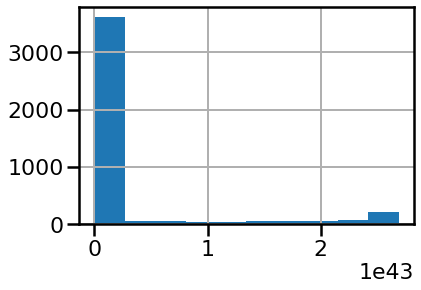

In [ ]:
df_af['acousticness_log']=(df_af['acousticness']+0.01).apply(expo)

#df_af['acousticness_log'].hist()
df_af['acousticness_log'].hist()
#df_af.columns



In [ ]:
# estandrarizamos por mix y max

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df_af)
df_af_scale = pd.DataFrame(scaled_df,columns=df_af.columns)
df_af_scale.head()

,danceability,energy,loudness,acousticness,instrumentalness,tempo,liveness_log,duration_ms_log,valence_log,speechiness_log,acousticness_log
0,0.638478,0.964909,0.891774,0.002851,0.854545,0.801047,0.358253,0.531208,0.371680,0.583242,2.478047e-10
1,0.071564,0.057668,0.431571,0.997992,0.572727,0.342310,0.463779,0.465292,0.160805,0.361557,1.992436e-46
2,0.273784,0.242044,0.647499,0.532129,0.000003,0.829509,0.339593,0.405968,0.386136,0.361110,1.365078e-43
3,0.255814,0.445569,0.830552,0.495984,0.000226,0.401823,0.580346,0.437123,0.238732,0.320521,1.700290e-43
4,0.741015,0.807503,0.872394,0.183735,0.003788,0.685235,0.476354,0.355811,0.887878,0.618496,6.518325e-42


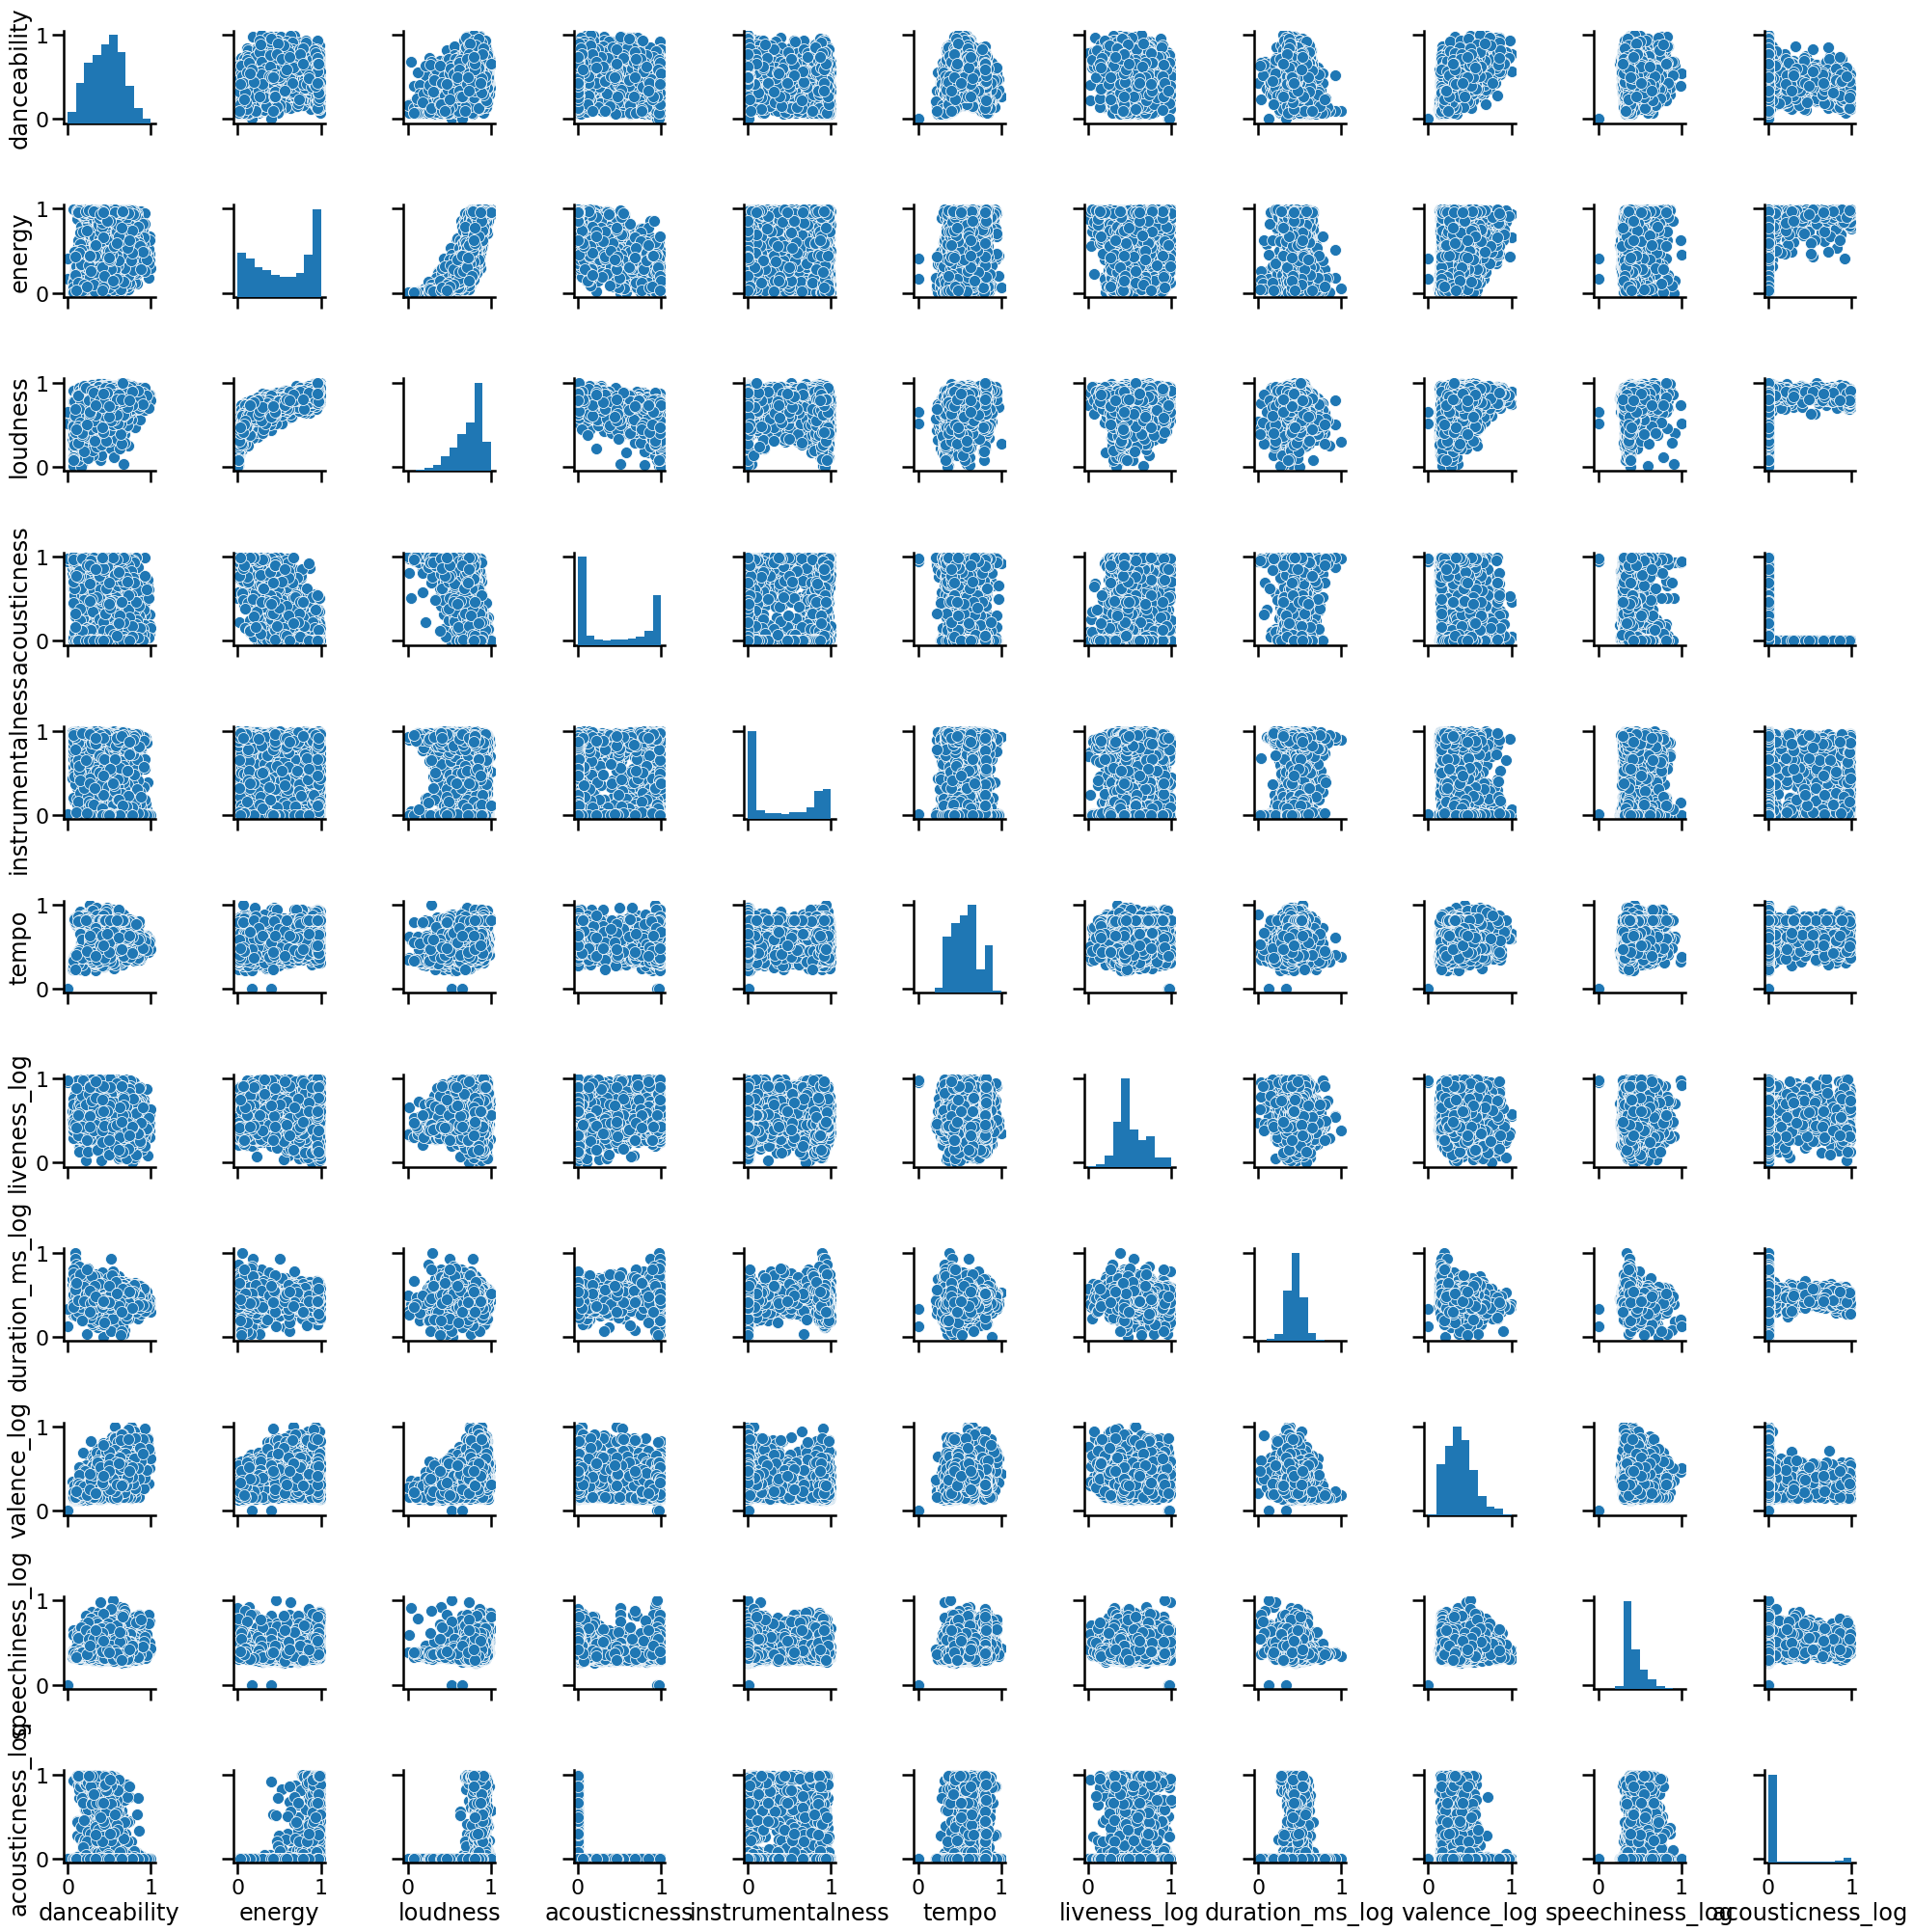

In [ ]:
sns.pairplot(df_af_scale);

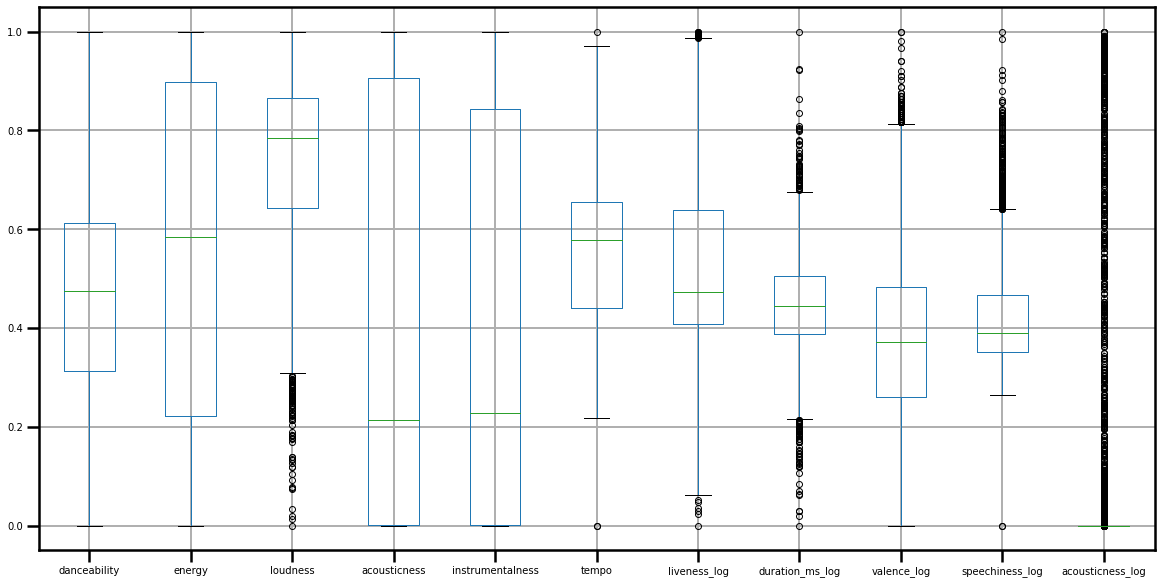

In [ ]:
# outliers univariados
df_af_scale.boxplot(fontsize=10,grid=True, figsize=(20,10))


# Dataset *audio_analysis*

El dataset *audio_analysis* contiene las variables continuas de bajo nivel, estimadas en ventanas temporales, como *timbre* o *pitches*. Como primer paso, deberán:

-   Resumir estas variables en valores por canción. Por ejemplo, tomar el promedio o el desvío estándar del timbre entre todas las ventanas, obteniendo 12 valores de timbre promedio y 12 valores de desvío estándar del timbre por canción.

-   Contruir un *data frame* con estos valores.

-   Generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

In [5]:
df_aa.head()
# falta de aca para abajo

,start,duration,confidence,loudness_start,loudness_max_time,loudness_max,loudness_end,pitches,timbre,id
0,0.00000,0.33061,0.000,-15.742,0.01269,-12.896,0.0,"[0.102, 0.103, 0.112, 0.21, 1.0, 0.068, 0.045,...","[43.022, 16.787, -40.89, 11.82, 105.068, -67.1...",6avAsaa2IsXHT2mtQ6cGVe
1,0.33061,0.36481,0.159,-22.482,0.08965,-18.792,0.0,"[0.008, 0.022, 0.029, 0.191, 1.0, 0.078, 0.013...","[38.644, -65.426, -9.06, -7.153, 135.949, -47....",6avAsaa2IsXHT2mtQ6cGVe
2,0.69542,0.53002,1.000,-23.472,0.00965,-7.144,0.0,"[0.037, 0.047, 0.063, 0.307, 1.0, 0.149, 0.06,...","[47.643, 50.817, 75.922, 53.108, 25.988, -42.0...",6avAsaa2IsXHT2mtQ6cGVe
3,1.22544,0.44059,0.626,-19.710,0.00809,-10.394,0.0,"[0.045, 0.067, 0.048, 0.131, 0.464, 0.104, 0.0...","[44.839, -20.55, 58.387, 38.347, 47.279, -59.7...",6avAsaa2IsXHT2mtQ6cGVe
4,1.66603,0.26816,0.082,-21.887,0.11164,-18.096,0.0,"[0.022, 0.045, 0.036, 0.149, 0.695, 0.147, 0.0...","[40.058, -29.617, 61.054, -12.254, 110.751, -4...",6avAsaa2IsXHT2mtQ6cGVe


In [6]:
df_aa.columns

Index(['start', 'duration', 'confidence', 'loudness_start',
       'loudness_max_time', 'loudness_max', 'loudness_end', 'pitches',
       'timbre', 'id'],
      dtype='object')

In [7]:
# vemos cuantos ids distintos tienen
df_aa['id'].value_counts()

4IIt36M11AQ5bHdzFQLEny    12374
4t3Yh6tKkxXrc458pNI7zZ     9519
0Ne5itrohiBOTy425hrBGJ     5622
7q85l1IotccRFlv3GgsvEU     5517
3kXJcMyhICI8U85Ce0WAED     5384
                          ...  
032rrZGB7Dr0YAcdgG31vV       97
0nNiyH4NViNdsL0JJz5yce       93
7DhJg9jCPljVOmUTXQ7dCy       73
0wvbb2MxlokwqSvbeoOOHv       65
6yYV3V3jqeWXinATQmngVc       57
Name: id, Length: 4177, dtype: int64

In [8]:
a=df_aa[df_aa['id']=='00At7PWydsvg7g5xgaYan9']['timbre'].apply(pd.Series)
#a[0].mean()
a

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000,171.130,9.469,-28.480,57.491,-50.067,14.833,5.359,-27.228,0.973,-10.640,-7.228
1,37.641,-77.643,-30.613,137.462,36.960,-51.024,-18.745,-28.822,-7.170,-1.994,-15.695,9.411
2,38.171,-17.741,-22.798,149.223,31.833,-53.446,-36.485,-39.479,-25.795,-1.903,-21.908,15.934
3,38.355,38.741,9.159,164.086,33.475,-83.620,-51.036,-23.505,-19.636,8.674,-18.950,6.718
4,40.292,38.220,-50.706,130.054,-4.597,-82.764,-32.596,-48.432,-21.086,20.443,-27.538,25.327
...,...,...,...,...,...,...,...,...,...,...,...,...
886,56.824,169.002,50.893,-4.497,77.509,-6.280,-31.490,-3.827,-8.619,-1.390,-22.228,-9.742
887,56.501,125.219,92.821,-10.895,123.496,-34.915,12.665,-13.193,-5.209,14.087,-17.509,-22.331
888,56.087,120.727,85.559,53.613,104.176,-42.061,-13.753,11.311,-21.318,-11.279,-21.996,7.502
889,57.070,126.266,65.693,20.776,80.150,-24.147,19.913,25.135,-0.312,1.195,8.402,-1.765


In [9]:
df_aa.shape

(4504350, 10)

In [10]:
gp = df_aa.groupby('id')
gp.first()

,start,duration,confidence,loudness_start,loudness_max_time,loudness_max,loudness_end,pitches,timbre
id,,,,,,,,,
00At7PWydsvg7g5xgaYan9,0.0,0.24381,0.000,-60.000,0.00000,-60.000,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
00BgcUYkIImsDN5rNjkR1U,0.0,0.16980,0.000,-17.313,0.01272,-14.302,0.0,"[0.152, 1.0, 0.339, 0.073, 0.107, 0.17, 0.055,...","[39.206, 168.479, -97.004, 66.837, 91.935, -59..."
00WgnFIsY1y84p7mYAJRuF,0.0,0.16816,0.000,-60.000,0.00000,-60.000,0.0,"[1.0, 0.776, 0.467, 0.338, 0.442, 0.453, 0.671...","[0.134, 170.681, 11.306, -32.086, 57.232, -51...."
00X2ieWUjpzdNwDU2Jlg6i,0.0,0.22054,0.000,-60.000,0.00000,-60.000,0.0,"[1.0, 0.739, 0.226, 0.295, 0.436, 0.529, 0.392...","[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
00isAURAZeKQXv6CW2vckb,0.0,0.57723,0.161,-60.000,0.55147,-55.255,0.0,"[0.552, 0.501, 0.46, 0.324, 0.116, 0.401, 0.42...","[1.48, 137.847, -22.243, -63.484, 41.726, -45...."
...,...,...,...,...,...,...,...,...,...
7zKweXON2KcgXizqUcu7lf,0.0,0.82426,1.000,-60.000,0.09948,-5.703,0.0,"[0.066, 0.189, 1.0, 0.065, 0.044, 0.04, 0.038,...","[28.992, 158.807, 115.118, -396.881, -9.121, 1..."
7zbRQboW74uyd6gp4zxZx0,0.0,0.24141,1.000,-52.842,0.07008,-10.582,0.0,"[0.936, 1.0, 0.491, 0.387, 0.406, 0.373, 0.255...","[22.317, 95.959, 42.215, -161.623, 15.791, 124..."
7zjWtWDCNgeXSY78nLzBQJ,0.0,0.38921,0.000,-60.000,0.00000,-60.000,0.0,"[1.0, 0.967, 0.799, 0.618, 0.486, 0.381, 0.518...","[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."


In [11]:
lista_col=[]
lista_col.append('id')
lista_col.extend(list('mean_pitch' + str(i) for i in range(12) ))
lista_col.extend(list('sd_pitch' + str(i) for i in range(12) ))
lista_col.extend(list('mean_timbre' + str(i) for i in range(12) ))
lista_col.extend(list('sd_timbre' + str(i) for i in range(12) ))

df_aux= pd.DataFrame(columns=lista_col)
df_aux

,id,mean_pitch0,mean_pitch1,mean_pitch2,mean_pitch3,mean_pitch4,mean_pitch5,mean_pitch6,mean_pitch7,mean_pitch8,mean_pitch9,mean_pitch10,mean_pitch11,sd_pitch0,sd_pitch1,sd_pitch2,sd_pitch3,sd_pitch4,sd_pitch5,sd_pitch6,sd_pitch7,sd_pitch8,sd_pitch9,sd_pitch10,sd_pitch11,mean_timbre0,mean_timbre1,mean_timbre2,mean_timbre3,mean_timbre4,mean_timbre5,mean_timbre6,mean_timbre7,mean_timbre8,mean_timbre9,mean_timbre10,mean_timbre11,sd_timbre0,sd_timbre1,sd_timbre2,sd_timbre3,sd_timbre4,sd_timbre5,sd_timbre6,sd_timbre7,sd_timbre8,sd_timbre9,sd_timbre10,sd_timbre11


In [12]:
df_aux.columns

Index(['id', 'mean_pitch0', 'mean_pitch1', 'mean_pitch2', 'mean_pitch3',
       'mean_pitch4', 'mean_pitch5', 'mean_pitch6', 'mean_pitch7',
       'mean_pitch8', 'mean_pitch9', 'mean_pitch10', 'mean_pitch11',
       'sd_pitch0', 'sd_pitch1', 'sd_pitch2', 'sd_pitch3', 'sd_pitch4',
       'sd_pitch5', 'sd_pitch6', 'sd_pitch7', 'sd_pitch8', 'sd_pitch9',
       'sd_pitch10', 'sd_pitch11', 'mean_timbre0', 'mean_timbre1',
       'mean_timbre2', 'mean_timbre3', 'mean_timbre4', 'mean_timbre5',
       'mean_timbre6', 'mean_timbre7', 'mean_timbre8', 'mean_timbre9',
       'mean_timbre10', 'mean_timbre11', 'sd_timbre0', 'sd_timbre1',
       'sd_timbre2', 'sd_timbre3', 'sd_timbre4', 'sd_timbre5', 'sd_timbre6',
       'sd_timbre7', 'sd_timbre8', 'sd_timbre9', 'sd_timbre10', 'sd_timbre11'],
      dtype='object')

In [13]:
gp.count()
# tienen que haber 4177 grupos en total

,start,duration,confidence,loudness_start,loudness_max_time,loudness_max,loudness_end,pitches,timbre
id,,,,,,,,,
00At7PWydsvg7g5xgaYan9,891,891,891,891,891,891,891,891,891
00BgcUYkIImsDN5rNjkR1U,993,993,993,993,993,993,993,993,993
00WgnFIsY1y84p7mYAJRuF,1476,1476,1476,1476,1476,1476,1476,1476,1476
00X2ieWUjpzdNwDU2Jlg6i,581,581,581,581,581,581,581,581,581
00isAURAZeKQXv6CW2vckb,815,815,815,815,815,815,815,815,815
...,...,...,...,...,...,...,...,...,...
7zKweXON2KcgXizqUcu7lf,822,822,822,822,822,822,822,822,822
7zbRQboW74uyd6gp4zxZx0,649,649,649,649,649,649,649,649,649
7zjWtWDCNgeXSY78nLzBQJ,680,680,680,680,680,680,680,680,680


In [16]:
df_aux.shape

(0, 49)

In [18]:
rows_df=[]
i=0
for fila_id, grupo in gp:
  # aplico series a los pitch y timbres para poder trabajarlos despues
  tmp_pitch=grupo['pitches'].apply(pd.Series)
  tmp_timbre=grupo['timbre'].apply(pd.Series)
  i=i+1

  # aplico media y desvio estandar
  pit1= tmp_pitch.apply(np.mean, axis=0)
  pit2= tmp_pitch.apply(np.std, axis=0)

  tim1= tmp_timbre.apply(np.mean, axis=0)
  tim2= tmp_timbre.apply(np.std, axis=0)
   
  # armo una fila para insertar en un dataframe
  lista_fila=[]
  lista_fila.append(fila_id)
  lista_fila.extend(pit1)
  lista_fila.extend(pit2)
  lista_fila.extend(tim1)
  lista_fila.extend(tim2)

  #agregamos a lista
  rows_df.append(lista_fila)
  print(i, fila_id)
 
df_aux= pd.DataFrame(rows_df, columns=df_aux.columns)
df_aux.head()

1 00At7PWydsvg7g5xgaYan9
2 00BgcUYkIImsDN5rNjkR1U
3 00WgnFIsY1y84p7mYAJRuF
4 00X2ieWUjpzdNwDU2Jlg6i
5 00isAURAZeKQXv6CW2vckb
6 00kO4Z0mFAFs6KLlXnaD0f
7 00nhkvorbdardFjuIi2OOo
8 00r6WtlzQELtNFjSfgQJas
9 01IEMsoSrK1WXJeuumBZX1
10 01K7WtcFrsolt07wYU8zTY
11 01MfWbgLTyyo0AIJ7sOeGy
12 01OXa5tVuCssU6j8TY7kxr
13 01cGujYWGF7JchJLSgf6Ta
14 01cY7Cc7t5zPB64uj8NGxz
15 01fpOKPgxIZripAqfM5zKd
16 01lhBjdfaTPsk9TKv0GGhp
17 029hlK8uy2JkLmjPV3wKN4
18 02ARurN3YINKqNGod37rt7
19 02Ldz6s7reMiMFThegV6Gu
20 02M2OoPaKPmkCl7kidq6nK
21 02PZzvMoGa2Jh6zh2des0v
22 02TadnJNMcVjr4baY39H1p
23 02cksNRxnzaM3lPk8zCuJO
24 02q6duD2HpNWJyDcgobAGQ
25 02yBnHZqIhYlnEhM3VLt7N
26 032rrZGB7Dr0YAcdgG31vV
27 03EuhmMsEHVFI9ytainStU
28 03HHqgSu89fgu6RFco0pit
29 03HwmxQ8w8gH1qU6BlmDrK
30 03LNtELU3mftqFQw8qYqrW
31 03pULHXZB4klVSLJsHh7h4
32 03vz24AIk3oIhCJBMrL4oM
33 03y0FwuuWSr0ReguaS0UBk
34 041O2IXtZ3Vdp555qyWP0W
35 0488kXJ1YnLMrrM1ssJnev
36 048AbE9LVZn2qc4mKxoEO9
37 04H0PtxuUqv8XYfaYVJGXs
38 04KAe25uribQjnSFJb8grm
39 04ZbcIONrJTCECTaYr

NameError: ignored

In [19]:
df_aux= pd.DataFrame(rows_df, columns=df_aux.columns)
df_aux.head()

,id,mean_pitch0,mean_pitch1,mean_pitch2,mean_pitch3,mean_pitch4,mean_pitch5,mean_pitch6,mean_pitch7,mean_pitch8,mean_pitch9,mean_pitch10,mean_pitch11,sd_pitch0,sd_pitch1,sd_pitch2,sd_pitch3,sd_pitch4,sd_pitch5,sd_pitch6,sd_pitch7,sd_pitch8,sd_pitch9,sd_pitch10,sd_pitch11,mean_timbre0,mean_timbre1,mean_timbre2,mean_timbre3,mean_timbre4,mean_timbre5,mean_timbre6,mean_timbre7,mean_timbre8,mean_timbre9,mean_timbre10,mean_timbre11,sd_timbre0,sd_timbre1,sd_timbre2,sd_timbre3,sd_timbre4,sd_timbre5,sd_timbre6,sd_timbre7,sd_timbre8,sd_timbre9,sd_timbre10,sd_timbre11
0,00At7PWydsvg7g5xgaYan9,0.372569,0.746600,0.288627,0.284531,0.279819,0.236079,0.303173,0.201448,0.372319,0.301180,0.289792,0.359101,0.278956,0.315104,0.226868,0.253471,0.269877,0.199185,0.258735,0.165056,0.272395,0.287251,0.291443,0.331024,54.798519,92.125193,35.913975,10.421557,49.833244,-32.670363,-2.777832,2.606419,-9.264416,6.457682,-9.620706,-2.132956,4.674393,36.152818,34.818777,34.868692,22.648563,24.314960,20.297972,18.424270,10.011592,12.286741,13.713586,11.749847
1,00BgcUYkIImsDN5rNjkR1U,0.255472,0.541902,0.147708,0.166854,0.286158,0.203731,0.405298,0.274106,0.499877,0.431839,0.294035,0.248160,0.236392,0.359939,0.157851,0.196883,0.315883,0.246249,0.351575,0.279845,0.353744,0.374848,0.264350,0.311768,53.810573,69.248870,-9.116627,-2.226798,37.537226,-42.652424,-0.684193,0.007623,-18.336879,0.615241,-8.178492,0.191112,5.365959,55.877179,38.559254,25.916739,30.750508,23.928167,21.883599,17.506083,15.533927,11.816519,15.302504,14.891460
2,00WgnFIsY1y84p7mYAJRuF,0.523316,0.378992,0.397866,0.515072,0.347002,0.338027,0.390105,0.584353,0.381764,0.325904,0.380690,0.252339,0.332723,0.302039,0.318739,0.353730,0.295090,0.294651,0.333636,0.349309,0.334210,0.310835,0.288197,0.249313,46.722248,50.900079,20.885997,15.719031,24.207190,-44.094831,14.521768,-0.068259,-20.861919,-2.182608,-3.503888,7.259081,8.478241,47.652920,70.874181,32.435488,37.451918,27.892557,26.128323,17.655452,15.848282,14.292686,14.665808,12.909679
3,00X2ieWUjpzdNwDU2Jlg6i,0.581520,0.582778,0.577449,0.349222,0.466081,0.296460,0.328719,0.459585,0.311110,0.403668,0.270599,0.347269,0.310101,0.301258,0.319801,0.210262,0.294603,0.216237,0.225375,0.308820,0.211838,0.284648,0.197873,0.247592,53.671623,51.902315,25.730107,-6.630838,10.632714,-27.621208,2.684391,5.400754,-3.055616,3.816508,-9.059971,-4.516873,3.414029,27.517160,24.974858,26.802161,18.629612,20.293563,16.982543,16.565502,13.537856,12.743424,12.529051,11.014681
4,00isAURAZeKQXv6CW2vckb,0.369134,0.536951,0.241599,0.378852,0.203259,0.335072,0.269961,0.249492,0.363373,0.204854,0.318196,0.155667,0.291137,0.348170,0.228895,0.356002,0.213297,0.324892,0.283743,0.248350,0.317578,0.212848,0.309932,0.178639,34.875225,-66.512445,40.915563,-10.102723,35.649973,-27.347364,-1.774950,0.008791,6.631508,-1.892666,-7.973755,-7.399080,6.857121,58.377532,35.071890,33.394240,27.040419,15.184624,38.374879,17.411062,23.760569,12.982456,13.483734,20.114356


In [20]:
df_aux.shape

(4177, 49)

In [21]:
df_aux.columns

Index(['id', 'mean_pitch0', 'mean_pitch1', 'mean_pitch2', 'mean_pitch3',
       'mean_pitch4', 'mean_pitch5', 'mean_pitch6', 'mean_pitch7',
       'mean_pitch8', 'mean_pitch9', 'mean_pitch10', 'mean_pitch11',
       'sd_pitch0', 'sd_pitch1', 'sd_pitch2', 'sd_pitch3', 'sd_pitch4',
       'sd_pitch5', 'sd_pitch6', 'sd_pitch7', 'sd_pitch8', 'sd_pitch9',
       'sd_pitch10', 'sd_pitch11', 'mean_timbre0', 'mean_timbre1',
       'mean_timbre2', 'mean_timbre3', 'mean_timbre4', 'mean_timbre5',
       'mean_timbre6', 'mean_timbre7', 'mean_timbre8', 'mean_timbre9',
       'mean_timbre10', 'mean_timbre11', 'sd_timbre0', 'sd_timbre1',
       'sd_timbre2', 'sd_timbre3', 'sd_timbre4', 'sd_timbre5', 'sd_timbre6',
       'sd_timbre7', 'sd_timbre8', 'sd_timbre9', 'sd_timbre10', 'sd_timbre11'],
      dtype='object')

In [28]:
df_tracks2.columns

Index(['artists', 'album', 'genre', 'release_date', 'album_name'], dtype='object')

In [29]:
df_tot=pd.merge(df_aux, df_tracks2, on='id', how='inner')
df_tot.head()


,id,mean_pitch0,mean_pitch1,mean_pitch2,mean_pitch3,mean_pitch4,mean_pitch5,mean_pitch6,mean_pitch7,mean_pitch8,mean_pitch9,mean_pitch10,mean_pitch11,sd_pitch0,sd_pitch1,sd_pitch2,sd_pitch3,sd_pitch4,sd_pitch5,sd_pitch6,sd_pitch7,sd_pitch8,sd_pitch9,sd_pitch10,sd_pitch11,mean_timbre0,mean_timbre1,mean_timbre2,mean_timbre3,mean_timbre4,mean_timbre5,mean_timbre6,mean_timbre7,mean_timbre8,mean_timbre9,mean_timbre10,mean_timbre11,sd_timbre0,sd_timbre1,sd_timbre2,sd_timbre3,sd_timbre4,sd_timbre5,sd_timbre6,sd_timbre7,sd_timbre8,sd_timbre9,sd_timbre10,sd_timbre11,artists,album,genre,release_date,album_name
0,00At7PWydsvg7g5xgaYan9,0.372569,0.746600,0.288627,0.284531,0.279819,0.236079,0.303173,0.201448,0.372319,0.301180,0.289792,0.359101,0.278956,0.315104,0.226868,0.253471,0.269877,0.199185,0.258735,0.165056,0.272395,0.287251,0.291443,0.331024,54.798519,92.125193,35.913975,10.421557,49.833244,-32.670363,-2.777832,2.606419,-9.264416,6.457682,-9.620706,-2.132956,4.674393,36.152818,34.818777,34.868692,22.648563,24.314960,20.297972,18.424270,10.011592,12.286741,13.713586,11.749847,Matrix & Futurebound,"{'album_type': 'ALBUM', 'artists': [{'external...",drum-and-bass,2012,All I Know EP (feat. Luke Bingham)
1,00BgcUYkIImsDN5rNjkR1U,0.255472,0.541902,0.147708,0.166854,0.286158,0.203731,0.405298,0.274106,0.499877,0.431839,0.294035,0.248160,0.236392,0.359939,0.157851,0.196883,0.315883,0.246249,0.351575,0.279845,0.353744,0.374848,0.264350,0.311768,53.810573,69.248870,-9.116627,-2.226798,37.537226,-42.652424,-0.684193,0.007623,-18.336879,0.615241,-8.178492,0.191112,5.365959,55.877179,38.559254,25.916739,30.750508,23.928167,21.883599,17.506083,15.533927,11.816519,15.302504,14.891460,Maduk,"{'album_type': 'ALBUM', 'artists': [{'external...",drum-and-bass,2013,Feel Good
2,00WgnFIsY1y84p7mYAJRuF,0.523316,0.378992,0.397866,0.515072,0.347002,0.338027,0.390105,0.584353,0.381764,0.325904,0.380690,0.252339,0.332723,0.302039,0.318739,0.353730,0.295090,0.294651,0.333636,0.349309,0.334210,0.310835,0.288197,0.249313,46.722248,50.900079,20.885997,15.719031,24.207190,-44.094831,14.521768,-0.068259,-20.861919,-2.182608,-3.503888,7.259081,8.478241,47.652920,70.874181,32.435488,37.451918,27.892557,26.128323,17.655452,15.848282,14.292686,14.665808,12.909679,Apex,"{'album_type': 'ALBUM', 'artists': [{'external...",drum-and-bass,2012,Omega Point EP
3,00X2ieWUjpzdNwDU2Jlg6i,0.581520,0.582778,0.577449,0.349222,0.466081,0.296460,0.328719,0.459585,0.311110,0.403668,0.270599,0.347269,0.310101,0.301258,0.319801,0.210262,0.294603,0.216237,0.225375,0.308820,0.211838,0.284648,0.197873,0.247592,53.671623,51.902315,25.730107,-6.630838,10.632714,-27.621208,2.684391,5.400754,-3.055616,3.816508,-9.059971,-4.516873,3.414029,27.517160,24.974858,26.802161,18.629612,20.293563,16.982543,16.565502,13.537856,12.743424,12.529051,11.014681,The Mighty Mighty Bosstones,"{'album_type': 'ALBUM', 'artists': [{'external...",ska,2002,A Jackknife to a Swan
4,00isAURAZeKQXv6CW2vckb,0.369134,0.536951,0.241599,0.378852,0.203259,0.335072,0.269961,0.249492,0.363373,0.204854,0.318196,0.155667,0.291137,0.348170,0.228895,0.356002,0.213297,0.324892,0.283743,0.248350,0.317578,0.212848,0.309932,0.178639,34.875225,-66.512445,40.915563,-10.102723,35.649973,-27.347364,-1.774950,0.008791,6.631508,-1.892666,-7.973755,-7.399080,6.857121,58.377532,35.071890,33.394240,27.040419,15.184624,38.374879,17.411062,23.760569,12.982456,13.483734,20.114356,Gottfried Heinrich Stölzel,"{'album_type': 'ALBUM', 'artists': [{'external...",classical,2015,Divine Redeemer


In [30]:
df_tot.shape

(4082, 54)